In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings #Latex Syntax for Plotting
using ITensors
using Plots

import ITensors: op # Allows overloading of ITensors.op

$$ H = -t\sum_{\sigma = \uparrow, \downarrow} \sum_{j = 1}^{N - 1}( c^{\dagger}_{j, \sigma}c_{j+1, \sigma} + h.c.)+U \sum_{j = 1}^{N} n_{j \uparrow} n_{j \downarrow}$$

**Exact Diagonalization Functions:**

In [2]:
C_up = [0 1 0 0; 0 0 0 0; 0 0 0 1; 0 0 0 0] #C_↑
Cdag_up = adjoint(C_up) #C†_↑
C_down = [0 0 1 0; 0 0 0 -1; 0 0 0 0; 0 0 0 0] #C_↓
Cdag_down = adjoint(C_down) #C†_↓
n_up = Cdag_up*C_up #n_↑
n_down = Cdag_down*C_down #n_↓
# P = (-1.0 + 0im)^(n_up + n_down)
P = [1 0 0 0; 0 -1 0 0; 0 0 -1 0; 0 0 0 1] #Parity Operator

4×4 Matrix{Int64}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

In [3]:
function Enlarge_Matrix_site_j(j, N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I

    Identity = zeros(size(matrix))
    for i=1:size(matrix)[1]
        Identity[i,i] = 1
    end
    
    M = Identity
    
    if j == 1
        M = matrix
    end    
    
    for i=2:N 
        if i == j
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

function Enlarge_Matrix_i_Matrix_j(i,j,N, matrix_i, matrix_j)
    # I⊗...⊗I⊗M_i⊗I...⊗I⊗M_j⊗I⊗I...⊗I

    Identity = zeros(size(matrix_i))
    for i=1:size(matrix_i)[1]
        Identity[i,i] = 1
    end

    M = Identity
    
    if j == 1
        M = matrix_j
    end    

    if i == 1
        M = matrix_i
    end   
    
    for k=2:N 
        if k == j
        M = kron(M, matrix_j)
        elseif k == i
        M = kron(M, matrix_i)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_i_Matrix_j (generic function with 1 method)

In [4]:
# Enlarge_Matrix_i_Matrix_j(2,3,4, Cdag_up*P, C_up) == kron(P*P, Cdag_up*P, C_up, P*P) #Test

In [5]:
function Build_Hamiltonian(t,U, N)

    H = zeros(4^N, 4^N) #Local Hilbert Space Dimension = 4
    
    for k=1:N-1
        H += -t*Enlarge_Matrix_i_Matrix_j(k,k+1,N, Cdag_up*P, C_up) #C†_j,↑*#C_j+1,↑
        H += -t*Enlarge_Matrix_i_Matrix_j(k,k+1,N, Cdag_down*P, C_down) #C†_j,↓*#C_j+1,↓
    end
    H += adjoint(H) #h.c.

    for k=1:N
        H += U*Enlarge_Matrix_site_j(k, N, n_up*n_down) #n_↑*n_↓
    end

    return H
end

function Time_Evolution_Operator(t, H)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    return U = exp(-1im*t*H)   
end

function double_occupancy_ED(psi)
    N = log2(length(psi))/2

    d = 0
    for j in 1:N
        Op = Enlarge_Matrix_site_j(j, N, n_up*n_down)
        d += adjoint(psi)*Op*psi
    end
    
   return d/N     
end

function staggered_magnetization_ED(psi)
    N = log2(length(psi))/2
    
    ms = 0
    for j in 1:N
        Nup = Enlarge_Matrix_site_j(j, N, n_up)
        Ndn = Enlarge_Matrix_site_j(j, N, n_down)
        ms += (-1)^(j)*(adjoint(psi)*Nup*psi - adjoint(psi)*Ndn*psi)
    end
    
    return ms/(2*N) 
end

staggered_magnetization_ED (generic function with 1 method)

**ITensor Functions:**

In [6]:
#Definitions JJ:

op(::OpName"PCup",::SiteType"Electron") = [0 1 0 0
                                           0 0 0 0
                                           0 0 0 -1
                                           0 0 0 0]; 

op(::OpName"PCdn",::SiteType"Electron") = [0 0 1 0
                                           0 0 0 1
                                           0 0 0 0
                                           0 0 0 0];

op(::OpName"CdagupP",::SiteType"Electron") = [0 0 0 0
                                              1 0 0 0
                                              0 0 0 0
                                              0 0 -1 0]; 

op(::OpName"CdagdnP",::SiteType"Electron") = [0 0 0 0
                                              0 0 0 0
                                              1 0 0 0
                                              0 1 0 0];

# New version of creation and annihilation operators to use OpSum

op(::OpName"CupNew",::SiteType"Electron") = [0 1 0 0
                                             0 0 0 0
                                             0 0 0 1
                                             0 0 0 0]; 

op(::OpName"CdnNew",::SiteType"Electron") = [0 0 1 0
                                             0 0 0 -1
                                             0 0 0 0
                                             0 0 0 0];

op(::OpName"CdagupNew",::SiteType"Electron") = [0 0 0 0
                                                1 0 0 0
                                                0 0 0 0
                                                0 0 1 0]; 

op(::OpName"CdagdnNew",::SiteType"Electron") = [0 0 0 0
                                                0 0 0 0
                                                1 0 0 0
                                                0 -1 0 0];


In [164]:
function Create_H_MPO(t,U, N, sites = []) 

    if length(sites) == 0
        sites = siteinds("Electron",N)    
    end
    
    os = OpSum() 
    for j=1:N-1 

        #JJ Code: This version is working
        
        # os += -t,"CdagdnP",j,"CdnNew",j+1
        # os += -t,"PCdn",j,"CdagdnNew",j+1
        # os += -t,"CdagupP",j,"CupNew",j+1
        # os += -t,"PCup",j,"CdagupNew",j+1   

        #What if we remove New because they are the same? This version is not working
        # os += -t,"CdagdnP",j,"Cdn",j+1
        # os += -t,"PCdn",j,"Cdagdn",j+1
        # os += -t,"CdagupP",j,"Cup",j+1
        # os += -t,"PCup",j,"Cdagup",j+1               

        #Using default operators Attempt: This version is working

        os += -t,"Cdagup",j,"Cup",j+1 
        os += -t,"Cdagup",j+1,"Cup",j
        os += -t,"Cdagdn",j,"Cdn",j+1 
        os += -t,"Cdagdn",j+1,"Cdn",j

        #Our F is the parity operator, what if we write this? This version is not working
        # os += -t,"Cdagdn * F",j,"Cdn",j+1
        # os += -t,"Cdagdn",j+1,"F * Cdn",j
        # os += -t,"Cdagup * F",j,"Cup",j+1
        # os += -t,"Cdagup",j+1,"F * Cup",j     
    
    end 

    for j=1:N
        os += U,"Nup * Ndn",j
    end
    # Convert these terms to an MPO 
    H = MPO(os,sites)
    return H, sites
end

function double_occupancy_TN(psi)
    N = length(psi)
    sites = siteinds(psi)
    
    d = 0
    for j in 1:N
        Nup = op("Nup", sites[j])
        Ndn = op("Ndn", sites[j])
        d += inner(psi, apply(Nup, apply(Ndn,psi)))
    end
    
    return d/N 
end

function staggered_magnetization_TN(psi)
    N = length(psi)
    sites = siteinds(psi)
    
    ms = 0
    for j in 1:N
        Nup = op("Nup", sites[j])
        Ndn = op("Ndn", sites[j])
        ms += (-1)^(j)*(inner(psi, apply(Nup,psi)) - inner(psi, apply(Ndn,psi)))
    end
    
    return ms/(2*N) 
end

function TEBD_Values(t, Psi_0, J, U, maxdim = 40, output = false, iTEBD = false)
    #|Ψ(t)> = exp(-itH)|Ψ(0)> #Main Function

    N = length(Psi_0)
    cutoff = 1E-8
    dt = 0.005
    s = siteinds(Psi_0)
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
        s1 = s[j]
        s2 = s[j + 1]

        # hj = -J*op("Cdagup", s1)*op("Cup", s2) -J*op("Cdagup", s2)*op("Cup", s1) 
        # hj += -J*op("Cdagdn", s1)*op("Cdn", s2) -J*op("Cdagdn", s2)*op("Cdn", s1) 
        
        hj = -J*op("Cdagup * F", s1)*op("Cup", s2) -J*op("Cdagup", s2)*op("F * Cup", s1) 
        hj += -J*op("Cdagdn * F", s1)*op("Cdn", s2) -J*op("Cdagdn", s2)*op("F * Cdn", s1)  

        hj += U*op("Nup * Ndn", s1)*op("Id", s2)

        if j == N-1
            hj += U*op("Nup * Ndn", s2)*op("Id", s1)
        end

        if iTEBD
            push!(Evolution_Gates, exp(-dt/ 2 * hj))
        else
            push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
        end
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    d_values = [double_occupancy_TN(Psi_0)] 
    ms_values = [staggered_magnetization_TN(Psi_0)]
    
    Times = [0.0]
    
    Psi_t = Psi_0    
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff, maxdim)  #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
        normalize!(Psi_t)

        append!(Times, time)
        
        if iTEBD
            append!(d_values, double_occupancy_TN(Psi_t))
            append!(ms_values, staggered_magnetization_TN(Psi_t))
        else        
            append!(d_values, double_occupancy_TN(Psi_t).re)
            append!(ms_values, staggered_magnetization_TN(Psi_t).re)
        end

        if output == true
            println("Values for t = "*string(time)*" calculated.")
        end
    end
    
    return d_values, ms_values, Times
end

TEBD_Values (generic function with 4 methods)

In [132]:
N = 6
t = 1
U = 4
tf = 2

2

In [133]:
#First run values:

# N = 4
# tf = 0.1

In [134]:
nsweeps = 10
maxdim = [500] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

1-element Vector{Float64}:
 1.0e-10

In [135]:
H, sites = Create_H_MPO(t,U, N) 
DMRG_observer = DMRGObserver(;energy_tol=10e-8, minsweeps=10, energy_type=Float64)
energy_ground_state, psi_ground_state = dmrg(H,randomMPS(sites); nsweeps, maxdim, cutoff, observer = DMRG_observer) 

After sweep 1 energy=-4.045905497769499  maxlinkdim=16 maxerr=1.11E-16 time=0.024
After sweep 2 energy=-4.37701508288995  maxlinkdim=60 maxerr=8.78E-11 time=0.217
After sweep 3 energy=-4.418984018871458  maxlinkdim=58 maxerr=7.16E-11 time=0.220
After sweep 4 energy=-4.421898184458092  maxlinkdim=54 maxerr=8.51E-11 time=0.225
After sweep 5 energy=-4.422067103811092  maxlinkdim=44 maxerr=8.41E-11 time=0.198
After sweep 6 energy=-4.422071095958042  maxlinkdim=25 maxerr=9.01E-11 time=0.124
After sweep 7 energy=-4.422071147155771  maxlinkdim=25 maxerr=5.10E-11 time=0.096
After sweep 8 energy=-4.4220711475301675  maxlinkdim=25 maxerr=3.50E-11 time=0.081
After sweep 9 energy=-4.422071147530359  maxlinkdim=25 maxerr=3.19E-11 time=0.087
After sweep 10 energy=-4.422071147530258  maxlinkdim=25 maxerr=3.19E-11 time=0.076


(-4.422071147530258, MPS
[1] ((dim=4|id=249|"Link,l=1"), (dim=4|id=661|"Electron,Site,n=1"))
[2] ((dim=16|id=438|"Link,l=2"), (dim=4|id=449|"Electron,Site,n=2"), (dim=4|id=249|"Link,l=1"))
[3] ((dim=4|id=609|"Electron,Site,n=3"), (dim=25|id=105|"Link,l=3"), (dim=16|id=438|"Link,l=2"))
[4] ((dim=4|id=41|"Electron,Site,n=4"), (dim=16|id=441|"Link,l=4"), (dim=25|id=105|"Link,l=3"))
[5] ((dim=4|id=842|"Electron,Site,n=5"), (dim=4|id=444|"Link,l=5"), (dim=16|id=441|"Link,l=4"))
[6] ((dim=4|id=236|"Electron,Site,n=6"), (dim=4|id=444|"Link,l=5"))
)

In [129]:
# Matrix(op("Cdagup", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagupNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagdn", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagdnNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdn", sites[1]),sites[1]',sites[1]) == Matrix(op("CdnNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdn", sites[1]),sites[1]',sites[1]) == Matrix(op("CdnNew", sites[1]),sites[1]',sites[1]) 
# Matrix(op("F * Cdn", sites[1]),sites[1]',sites[1]) == Matrix(op("PCdn", sites[1]),sites[1]',sites[1]) 
# Matrix(op("F * Cup", sites[1]),sites[1]',sites[1]) == Matrix(op("PCup", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagup * F", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagupP", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagdn * F", sites[1]),sites[1]',sites[1]) == Matrix(op("CdagdnP", sites[1]),sites[1]',sites[1]) 
# Matrix(op("Cdagup * F", sites[1]),sites[1]',sites[1]) == Cdag_up*P

In [130]:
H_ED = Build_Hamiltonian(t,U, N)
values, vectors = eigen(H_ED)
Psi_0 = vectors[:,1]
values

4096-element Vector{Float64}:
 -4.422071147758748
 -4.063601640902709
 -4.063601640902709
 -4.063601640902709
 -4.063311949299884
 -4.063311949299884
 -3.9843589627621956
 -3.9843589627621956
 -3.7156715880653834
 -3.7156715880653834
 -3.6876257811430326
 -3.687625781143029
 -3.687625781143029
  ⋮
 20.130534197834915
 20.445041867912625
 20.445041867912625
 20.460446370594543
 20.872336983871616
 21.246979603717467
 21.246979603717467
 21.263081178266564
 21.549102862741815
 21.80193773580483
 21.801937735804838
 24.0

In [102]:
# adjoint(op("F * Cdn", sites[1]))*delta(sites[1]', sites[1])*delta(sites[1]'', sites[1]')

ITensor ord=2 (dim=4|id=668|"Electron,Site,n=1") (dim=4|id=668|"Electron,Site,n=1")'
NDTensors.Dense{Float64, Vector{Float64}}

In [36]:
double_occupancy_ED(Psi_0), double_occupancy_TN(psi_ground_state)

(0.0367583620801699, 0.03675836200960071)

In [37]:
staggered_magnetization_ED(Psi_0), staggered_magnetization_TN(psi_ground_state)

(5.088522196198634e-17, -8.365056517837625e-10)

In [38]:
Initial_State = []
for i=1:N

    if i%2==0
        append!(Initial_State, ["Up"])
    else
        append!(Initial_State, ["Dn"])
    end
end

In [39]:
Initial_State

6-element Vector{Any}:
 "Dn"
 "Up"
 "Dn"
 "Up"
 "Dn"
 "Up"

In [40]:
H, sites = Create_H_MPO(t,U, N) 
Initial_MPS = MPS(sites, Initial_State)
normalize!(Initial_MPS)

MPS
[1] ((dim=4|id=668|"Electron,Site,n=1"), (dim=1|id=497|"Link,l=1"))
[2] ((dim=1|id=497|"Link,l=1"), (dim=4|id=345|"Electron,Site,n=2"), (dim=1|id=83|"Link,l=2"))
[3] ((dim=1|id=83|"Link,l=2"), (dim=4|id=133|"Electron,Site,n=3"), (dim=1|id=94|"Link,l=3"))
[4] ((dim=1|id=94|"Link,l=3"), (dim=4|id=672|"Electron,Site,n=4"), (dim=1|id=203|"Link,l=4"))
[5] ((dim=1|id=203|"Link,l=4"), (dim=4|id=981|"Electron,Site,n=5"), (dim=1|id=787|"Link,l=5"))
[6] ((dim=1|id=787|"Link,l=5"), (dim=4|id=131|"Electron,Site,n=6"))


In [141]:
d_values_TN, ms_values_TN, times_TN = TEBD_Values(tf, Initial_MPS, t, U)

([0.0, 4.1661580242315445e-5, 0.00016660258399644055, 0.00037469498388811943, 0.0006657276725814138, 0.0010393845841919788, 0.0014951842425696973, 0.0020325804631254724, 0.0026509296116829016, 0.0033494915382012054  …  0.10473663359266566, 0.10468580820001243, 0.10462516221377353, 0.10455484882686923, 0.10447503915006807, 0.10438592174786065, 0.10428770214342005, 0.1041806022938364, 0.10406486003686925, 0.10394072851050944], [0.5, 0.4999583375865062, 0.49983338408650296, 0.4996252375562358, 0.499334059211779, 0.4989600112117532, 0.4985033227123217, 0.4979642946068196, 0.49734328178611237, 0.496640692782159  …  -0.049187895847858286, -0.049405644439659634, -0.04962182275341106, -0.049836436949480124, -0.050049486872999316, -0.050260966157553766, -0.05047086233616338, -0.0506791569593504, -0.05088582572008452, -0.05109083858538932], [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045  …  1.955, 1.96, 1.965, 1.97, 1.975, 1.98, 1.985, 1.99, 1.995, 2.0])

In [118]:
up = [0.0; 1.0; 0.0; 0.0]
dn = [0.0; 0.0; 1.0; 0.0]

Initial_vector = kron(dn,up,dn,up,dn,up)
# Initial_vector = kron(dn,up,dn,up)

4096-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [119]:
dt = 0.01

U_Operator = Time_Evolution_Operator(dt, H_ED)

d_values_ED = [double_occupancy_ED(Initial_vector)] 
ms_values_ED = [staggered_magnetization_ED(Initial_vector)]
times_ED = [0.0]

Psi_t = Initial_vector

for k=1:Integer(tf/dt)
    
    Psi_t = U_Operator*Psi_t
    append!(d_values_ED, double_occupancy_ED(Psi_t))
    append!(ms_values_ED, staggered_magnetization_ED(Psi_t))
    append!(times_ED, dt*k)
end

In [120]:
d_values_ED, ms_values_ED, times_ED

([0.0, 0.00016660001276889603, 0.0006656008169263521, 0.0014946092999327547, 0.0026496522109273886, 0.004125198962206446, 0.005914193344894944, 0.008008093954188738, 0.010396923063595997, 0.013069323633521498  …  0.10400913622356374, 0.10409509206828314, 0.10414355004696745, 0.10415461931497738, 0.10412871211893214, 0.10406653552573457, 0.10396908085494393, 0.10383761092934228, 0.10367364527472224, 0.10347894341488102], [0.5, 0.49983336999523037, 0.49933391969480184, 0.4985029665250722, 0.49734270048721757, 0.49585617562172946, 0.4940472981157769, 0.4919208111101103, 0.48948227627783175, 0.48673805226253014  …  -0.047178198756128276, -0.04764194790540779, -0.048097695053281174, -0.04854590792302024, -0.048986949163883124, -0.049421077883030386, -0.04984845169657485, -0.050269129277877245, -0.05068307337922518, -0.051090154301209535], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.9100000000000001, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0])

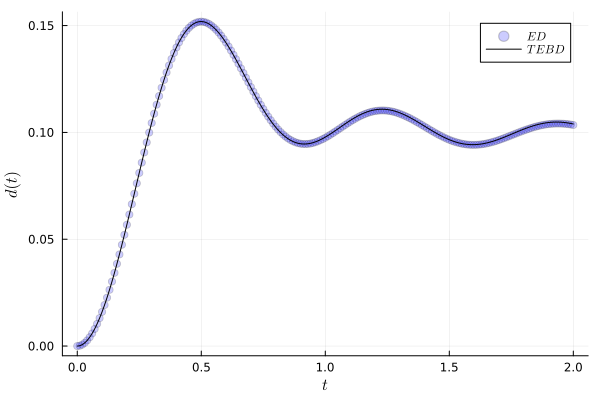

In [147]:
scatter(times_ED, d_values_ED, label= L"ED", color = "blue", alpha = 0.2)
plot!(times_TN, d_values_TN, label= L"TEBD", color = "black")
xlabel!(L"t")
ylabel!(L"d(t)")

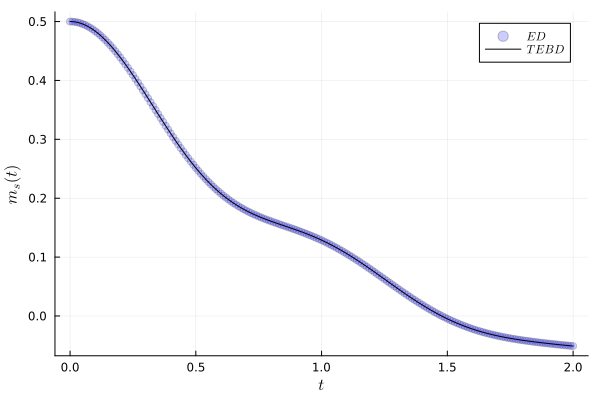

In [148]:
scatter(times_ED, ms_values_ED, label= L"ED", color = "blue", alpha = 0.2)
plot!(times_TN, ms_values_TN, label= L"TEBD", color = "black")
xlabel!(L"t")
ylabel!(L"m_{s}(t)")

In [182]:
N = 10
t = 1
U = 4
tf = 3

3

In [183]:
Initial_State = []
for i=1:N

    if i%2==0
        append!(Initial_State, ["Up"])
    else
        append!(Initial_State, ["Dn"])
    end
end

In [184]:
Initial_State

10-element Vector{Any}:
 "Dn"
 "Up"
 "Dn"
 "Up"
 "Dn"
 "Up"
 "Dn"
 "Up"
 "Dn"
 "Up"

In [185]:
H, sites = Create_H_MPO(t,U, N) 
Initial_MPS = MPS(sites, Initial_State)
normalize!(Initial_MPS)

MPS
[1] ((dim=4|id=623|"Electron,Site,n=1"), (dim=1|id=651|"Link,l=1"))
[2] ((dim=1|id=651|"Link,l=1"), (dim=4|id=909|"Electron,Site,n=2"), (dim=1|id=553|"Link,l=2"))
[3] ((dim=1|id=553|"Link,l=2"), (dim=4|id=556|"Electron,Site,n=3"), (dim=1|id=340|"Link,l=3"))
[4] ((dim=1|id=340|"Link,l=3"), (dim=4|id=721|"Electron,Site,n=4"), (dim=1|id=419|"Link,l=4"))
[5] ((dim=1|id=419|"Link,l=4"), (dim=4|id=659|"Electron,Site,n=5"), (dim=1|id=14|"Link,l=5"))
[6] ((dim=1|id=14|"Link,l=5"), (dim=4|id=110|"Electron,Site,n=6"), (dim=1|id=63|"Link,l=6"))
[7] ((dim=1|id=63|"Link,l=6"), (dim=4|id=67|"Electron,Site,n=7"), (dim=1|id=702|"Link,l=7"))
[8] ((dim=1|id=702|"Link,l=7"), (dim=4|id=463|"Electron,Site,n=8"), (dim=1|id=564|"Link,l=8"))
[9] ((dim=1|id=564|"Link,l=8"), (dim=4|id=187|"Electron,Site,n=9"), (dim=1|id=214|"Link,l=9"))
[10] ((dim=1|id=214|"Link,l=9"), (dim=4|id=919|"Electron,Site,n=10"))


In [186]:
d_values_TN, ms_values_TN, times_TN = TEBD_Values(tf, Initial_MPS, t, U, 100, false, false)

([0.0, 4.4994198374091754e-5, 0.0001799275589348559, 0.00040465582212901593, 0.0007189410280482284, 0.0011224279141222998, 0.0016145786891254676, 0.0021947818357424204, 0.0028623168254318337, 0.0036163552107596484  …  0.10428680112247576, 0.10434458992928979, 0.10440993110269262, 0.10448271953944348, 0.10456283539401594, 0.10465014434084177, 0.10474449786449196, 0.10484573357723444, 0.10495367556337762, 0.10506813474976744], [0.5, 0.4999550048017297, 0.4998200564458518, 0.49959526322781056, 0.4992808032425704, 0.49887685718954644, 0.4983836796864322, 0.49780160437174387, 0.49713102472248016, 0.49637239364118946  …  0.002073667123175582, 0.0023503712586888186, 0.002623846546406755, 0.0028941323998313865, 0.003161268792194785, 0.0034252961902625943, 0.003686255490166829, 0.0039441879550600936, 0.004199135154364847, 0.004451138904374502], [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045  …  2.955, 2.96, 2.965, 2.97, 2.975, 2.98, 2.985, 2.99, 2.995, 3.0])

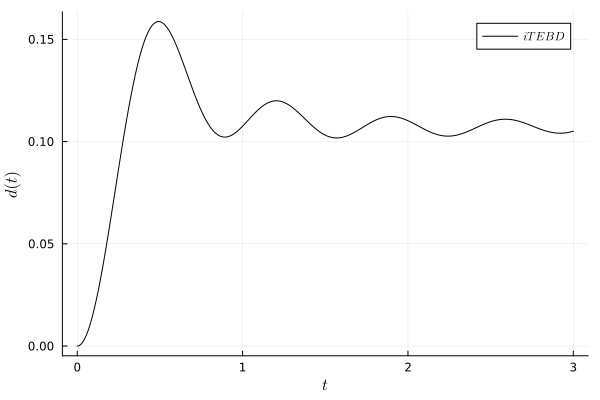

In [187]:
plot(times_TN, d_values_TN, label= L"iTEBD", color = "black")
xlabel!(L"t")
ylabel!(L"d(t)")

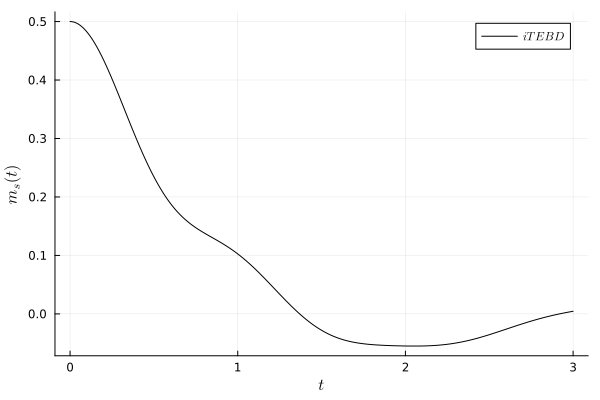

In [188]:
plot(times_TN, ms_values_TN, label= L"iTEBD", color = "black")
xlabel!(L"t")
ylabel!(L"m_{s}(t)")